# UNION PPO distillation notebook
Distill a POP-style ensemble (or a single teacher) into a single **CNet192** using **true logits-mixture** targets.

**Key idea:** PPO teachers can have small-magnitude logits. If you distill with a plain softmax at T=1, targets can become *too uniform*, and the student becomes… well… enthusiastic but unhelpful. So we add temperature + optional hardening toward the greedy action.


In [1]:
# Cell 1: imports + global seeds (single-channel only)

from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Sequence, Tuple, Optional

import os
import math
import random

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

from C4.connect4_env import Connect4Env
from C4.CNet192 import CNet192, load_cnet192, save_cnet192
from PPO.ppo_hall_of_fame import PPOHallOfFame  # used ONLY for loading teacher checkpoints

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# --- global seeds ---
SEED = 666
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

N_ACTIONS = 7

# Optional: keep Torch deterministic-ish (costs some perf)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


Using device: cuda


In [2]:
# Cell 2: knobs (keep all the marbles in one bowl)

# Distill dataset
EPISODES     = 7500
MAX_SAMPLES  = 300_000
MAX_MOVES    = 42

# Student training
BATCH_SIZE   = 512
LR           = 3e-4
WD           = 1e-5
NUM_EPOCHS   = 20
GRAD_CLIP    = 1.0
VAL_SPLIT    = 0.10

# Teacher -> target distribution shaping (IMPORTANT)
# - Lower TEMP makes teacher targets sharper (closer to greedy behavior).
# - HARDEN_ALPHA blends in a one-hot of the greedy action to preserve tactics.
TEACHER_TEMP   = 0.35     # try 0.25 .. 0.6
HARDEN_ALPHA   = 0.35     # 0.0 = pure soft, 1.0 = pure one-hot greedy
MIX_LOGITS     = True     # True = average logits then softmax; False = average probs

# Rollout behavior (how we advance the env when generating states)
ROLLOUT_TEMP   = 0.0      # 0 => greedy from target_probs argmax; >0 can sample from target_probs

# I/O
OUT_DIR        = Path("PPO_Models/UNION_DISTILL")
OUT_DIR.mkdir(parents=True, exist_ok=True)

BEST_PATH      = OUT_DIR / "CNet192_UNION_best.pt"
LAST_PATH      = OUT_DIR / "CNet192_UNION_last.pt"

# ---- INPUT ONLY: teacher checkpoints + metascores ----
HOF_METASCORES = {
    #"PPO_Models/MIX_11.pt":  0.781000,
    "PPO_Models/MIX_12a.pt": 0.586667,
    #"PPO_Models/MIX_12b.pt": 0.507500,
}

# If you want to distill a single teacher, just leave ONE entry in HOF_METASCORES.
print("Teachers:", list(HOF_METASCORES.keys()))


Teachers: ['PPO_Models/MIX_12a.pt']


In [3]:
# Cell 3: load teachers via PPOHallOfFame (CNet192 checkpoints expected)

hof = PPOHallOfFame(device=DEVICE)

TEACHER_NAMES: List[str] = []
TEACHERS: Dict[str, torch.nn.Module] = {}
TEACHER_WEIGHTS: np.ndarray

for ckpt_path, ms in HOF_METASCORES.items():
    name = str(Path(ckpt_path).name).replace(".pt", "")
    hof.add_member(name=name, ckpt_path=str(ckpt_path), metascore=float(ms))

TEACHER_NAMES = hof.list_members()
hof.ensure_all_loaded()

# wrapped policies (HOF returns wrappers that accept (B,1,6,7) and return (logits,value))
for n in TEACHER_NAMES:
    TEACHERS[n] = hof.get_policy(n).to(DEVICE).eval()

# normalize weights from metascores (positive, sum=1)
w = np.array([float(hof.get_member(n).metascore or 1.0) for n in TEACHER_NAMES], dtype=np.float64)
w = np.maximum(w, 1e-12)
w = w / w.sum()
TEACHER_WEIGHTS = w.astype(np.float32)

print("Loaded teachers:", TEACHER_NAMES)
print("Weights:", {n: float(w) for n, w in zip(TEACHER_NAMES, TEACHER_WEIGHTS)})

# quick sanity: show each teacher's greedy move on empty board POV
env0 = Connect4Env()
env0.reset()
s0 = env0.get_state(perspective=env0.current_player)   # (1,6,7) float32 mover-centric
x0 = torch.from_numpy(s0[None, :, :, :]).to(DEVICE)    # (1,1,6,7)
legal0 = env0.available_actions()

with torch.inference_mode():
    for n in TEACHER_NAMES:
        out = TEACHERS[n](x0)
        logits = out[0] if isinstance(out, (tuple, list)) else out
        a = int(torch.argmax(logits[0]).item())
        print(f"{n:>12} greedy(empty) -> {a}   logits={logits[0].detach().cpu().numpy().round(3)}")


Loaded teachers: ['MIX_12a']
Weights: {'MIX_12a': 1.0}
     MIX_12a greedy(empty) -> 3   logits=[-80.898 -49.983 -57.841  22.158 -67.63  -53.491 -83.285]


In [4]:
# Cell 4: distillation helpers (single-channel only)

NEG_INF = -1e9

class DistillDataset(Dataset):
    def __init__(self, states: np.ndarray, targets: np.ndarray):
        assert states.ndim == 4 and states.shape[1:] == (1, 6, 7), states.shape
        assert targets.ndim == 2 and targets.shape[1] == N_ACTIONS, targets.shape
        self.states = states.astype(np.float32, copy=False)
        self.targets = targets.astype(np.float32, copy=False)

    def __len__(self) -> int:
        return int(self.states.shape[0])

    def __getitem__(self, idx: int):
        return self.states[idx], self.targets[idx]


@torch.inference_mode()
def _teacher_logits_np(teacher: torch.nn.Module, state_1x6x7: np.ndarray) -> np.ndarray:
    """
    teacher: wrapper from PPOHallOfFame (expects (B,1,6,7))
    state_1x6x7: np.ndarray (1,6,7) float32 mover-centric
    returns logits np.float32 shape (7,)
    """
    x = torch.from_numpy(state_1x6x7[None, :, :, :]).to(DEVICE)  # (1,1,6,7)
    out = teacher(x)
    logits = out[0] if isinstance(out, (tuple, list)) else out
    return logits[0].detach().float().cpu().numpy().astype(np.float32, copy=True)


def _softmax_masked(logits: np.ndarray, legal: Sequence[int], temp: float) -> np.ndarray:
    """Softmax over legal actions only; illegal actions get prob 0."""
    p = np.zeros((N_ACTIONS,), dtype=np.float32)
    legal = [int(a) for a in legal]
    if not legal:
        return p

    t = float(temp) if (temp is not None and temp > 0) else 1.0

    z = logits.astype(np.float32, copy=True)
    mask = np.zeros((N_ACTIONS,), dtype=bool)
    mask[legal] = True
    z[~mask] = NEG_INF

    # numerical stability (legal-only max)
    m = float(np.max(z[mask]))
    z = (z - m) / t

    # exp on legal only
    e = np.zeros_like(z, dtype=np.float32)
    e[mask] = np.exp(z[mask]).astype(np.float32)

    s = float(e[mask].sum())
    if s <= 0 or not np.isfinite(s):
        # fallback: uniform over legal
        p[legal] = 1.0 / float(len(legal))
        return p

    p[mask] = e[mask] / s
    return p


def _harden_probs(p: np.ndarray, legal: Sequence[int], alpha: float) -> np.ndarray:
    """Blend probs with one-hot greedy action to preserve tactical argmax behavior."""
    alpha = float(alpha)
    if alpha <= 0:
        return p.astype(np.float32, copy=False)

    legal = [int(a) for a in legal]
    if not legal:
        return p.astype(np.float32, copy=False)

    a = int(np.argmax(p))
    if a not in legal:
        # if argmax somehow illegal, pick best legal
        a = int(max(legal, key=lambda c: float(p[c])))

    one = np.zeros((N_ACTIONS,), dtype=np.float32)
    one[a] = 1.0
    out = (1.0 - alpha) * p.astype(np.float32) + alpha * one
    # renorm (safety)
    s = float(out.sum())
    if s > 0:
        out /= s
    return out.astype(np.float32, copy=False)


def ensemble_mixture_probs(
    state_np: np.ndarray,
    legal_actions: Sequence[int],
    teacher_temp: float = TEACHER_TEMP,
    harden_alpha: float = HARDEN_ALPHA,
    mix_logits: bool = MIX_LOGITS,
) -> np.ndarray:
    """
    True ensemble target distribution.

    Options:
      mix_logits=True:
        logits_mix = sum_i w_i * logits_i
        p = softmax_masked(logits_mix / T, legal)

      mix_logits=False:
        p = sum_i w_i * softmax_masked(logits_i / T, legal)

    Then optional hardening toward greedy with HARDEN_ALPHA.
    """
    legal = [int(a) for a in legal_actions]
    if not legal:
        return np.zeros((N_ACTIONS,), dtype=np.float32)

    if mix_logits:
        logits_mix = np.zeros((N_ACTIONS,), dtype=np.float32)
        for name, w in zip(TEACHER_NAMES, TEACHER_WEIGHTS):
            logits_i = _teacher_logits_np(TEACHERS[name], state_np)
            logits_mix += float(w) * logits_i
        p = _softmax_masked(logits_mix, legal=legal, temp=teacher_temp)
    else:
        p = np.zeros((N_ACTIONS,), dtype=np.float32)
        for name, w in zip(TEACHER_NAMES, TEACHER_WEIGHTS):
            logits_i = _teacher_logits_np(TEACHERS[name], state_np)
            p_i = _softmax_masked(logits_i, legal=legal, temp=teacher_temp)
            p += float(w) * p_i
        # renorm
        s = float(p.sum())
        if s > 0:
            p /= s

    p = _harden_probs(p, legal=legal, alpha=harden_alpha)
    return p.astype(np.float32, copy=False)


In [5]:
# Cell 5: generate distillation data (logits-mixture, single-channel)

def generate_distill_data(
    n_episodes: int,
    max_moves: int,
    max_samples: int,
    seed: int,
) -> DistillDataset:
    rng = np.random.default_rng(int(seed))
    random.seed(int(seed))
    torch.manual_seed(int(seed))
    if DEVICE.type == "cuda":
        torch.cuda.manual_seed_all(int(seed))

    states: List[np.ndarray] = []   # (1,6,7)
    targets: List[np.ndarray] = []  # (7,)
    total_samples = 0

    pbar = tqdm(range(int(n_episodes)), desc="Generating rollouts", leave=True)
    for ep in pbar:
        env = Connect4Env()
        env.reset()
        done = False
        moves = 0

        while (not done) and moves < int(max_moves) and total_samples < int(max_samples):
            legal = env.available_actions()
            if not legal:
                break

            # mover-centric single-channel state already: (1,6,7)
            s = env.get_state(perspective=env.current_player).astype(np.float32, copy=False)

            # teacher target distribution on this state
            target_probs = ensemble_mixture_probs(
                state_np=s,
                legal_actions=legal,
            )

            states.append(s)                 # keep (1,6,7)
            targets.append(target_probs)     # (7,)
            total_samples += 1
            moves += 1

            # advance env using target policy
            if ROLLOUT_TEMP and ROLLOUT_TEMP > 0:
                # sample from legal according to target_probs (renorm legal only)
                p_legal = np.array([target_probs[a] for a in legal], dtype=np.float64)
                ss = float(p_legal.sum())
                if ss <= 0:
                    a = int(rng.choice(legal))
                else:
                    p_legal /= ss
                    a = int(rng.choice(np.array(legal, dtype=np.int64), p=p_legal))
            else:
                a = int(target_probs.argmax())
                if a not in legal:
                    a = int(rng.choice(legal))

            _, _, done = env.step(a)

        pbar.set_postfix(samples=total_samples, last_len=moves)

        if total_samples >= int(max_samples):
            break

    states_arr = np.stack(states, axis=0)    # (N,1,6,7)
    targets_arr = np.stack(targets, axis=0)  # (N,7)

    print(f"Final distill dataset: states {states_arr.shape}, targets {targets_arr.shape}")
    return DistillDataset(states_arr, targets_arr)


# Kick off dataset generation
distill_dataset = generate_distill_data(
    n_episodes=EPISODES,
    max_moves=MAX_MOVES,
    max_samples=MAX_SAMPLES,
    seed=SEED,
)

len(distill_dataset)


Generating rollouts:   0%|          | 0/7500 [00:00<?, ?it/s]

Final distill dataset: states (127500, 1, 6, 7), targets (127500, 7)


127500

In [6]:
# Cell 6: train/val split + DataLoaders

N = len(distill_dataset)
idx = np.arange(N)
rng = np.random.default_rng(SEED)
rng.shuffle(idx)

n_val = max(1, int(round(VAL_SPLIT * N)))
val_idx = idx[:n_val]
train_idx = idx[n_val:]

train_states = distill_dataset.states[train_idx]
train_targets = distill_dataset.targets[train_idx]
val_states = distill_dataset.states[val_idx]
val_targets = distill_dataset.targets[val_idx]

train_ds = DistillDataset(train_states, train_targets)
val_ds   = DistillDataset(val_states,   val_targets)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=(DEVICE.type=="cuda"))
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=(DEVICE.type=="cuda"))

print("Train:", len(train_ds), " Val:", len(val_ds))


Train: 114750  Val: 12750


In [7]:
# Cell 7: student init + distillation training loop + loss histories + saves

student = CNet192(in_channels=1, use_mid_3x3=True).to(DEVICE)

optimizer = torch.optim.AdamW(student.parameters(), lr=LR, weight_decay=WD)

# KLDivLoss computes KL(target || exp(input)) when input=log_probs, target=probs
criterion = torch.nn.KLDivLoss(reduction="batchmean")

# Histories for plotting
train_loss_history: List[float] = []
val_loss_history: List[float] = []

def run_epoch(loader: DataLoader, train: bool, desc: str) -> float:
    student.train(bool(train))
    total_loss = 0.0
    total_items = 0

    it = tqdm(loader, desc=desc, leave=True)
    for states, targets in it:
        states = states.to(DEVICE, non_blocking=True)   # (B,1,6,7)
        targets = targets.to(DEVICE, non_blocking=True) # (B,7)

        if train:
            optimizer.zero_grad(set_to_none=True)

        out = student(states)
        logits = out[0] if isinstance(out, (tuple, list)) else out  # (B,7)

        log_probs = F.log_softmax(logits, dim=-1)
        loss = criterion(log_probs, targets)

        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student.parameters(), GRAD_CLIP)
            optimizer.step()

        bs = int(states.size(0))
        total_loss += float(loss.item()) * bs
        total_items += bs

        it.set_postfix(loss=float(loss.item()))

    return total_loss / max(1, total_items)


meta_base = {
    "source": "UNION_PPO_distill_logits_mixture",
    "teachers": list(HOF_METASCORES.keys()),
    "metascores": dict(HOF_METASCORES),
    "seed": int(SEED),
    "num_samples": int(len(distill_dataset)),
    "teacher_temp": float(TEACHER_TEMP),
    "harden_alpha": float(HARDEN_ALPHA),
    "mix_logits": bool(MIX_LOGITS),
    "rollout_temp": float(ROLLOUT_TEMP),
}

best_val = math.inf

for epoch in range(1, int(NUM_EPOCHS) + 1):
    tr = run_epoch(train_loader, train=True,  desc=f"Train {epoch}/{NUM_EPOCHS}")
    va = run_epoch(val_loader,   train=False, desc=f"Val   {epoch}/{NUM_EPOCHS}")

    train_loss_history.append(float(tr))
    val_loss_history.append(float(va))

    print(f"[Epoch {epoch:03d}] train_KL={tr:.6f}  val_KL={va:.6f}")

    if va < best_val:
        best_val = float(va)
        meta = dict(meta_base)
        meta.update({"tag": "best_val", "epoch": int(epoch), "best_val_loss": float(best_val)})

        # save_cnet192 signature: save_cnet192(path, model, cfg=None, **meta)
        save_cnet192(
            BEST_PATH,
            student,
            cfg={"input_channels": 1, "use_mid_3x3": True},
            **meta,
        )
        print(f"  -> New best model saved to: {BEST_PATH}")

# Save last
final_meta = dict(meta_base)
final_meta.update({"tag": "final", "epoch": int(NUM_EPOCHS), "best_val_loss": float(best_val)})

save_cnet192(
    LAST_PATH,
    student,
    cfg={"input_channels": 1, "use_mid_3x3": True},
    **final_meta,
)

print("Training complete.")
print(" Best model:", BEST_PATH)
print(" Final model:", LAST_PATH)


Train 1/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   1/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 001] train_KL=0.315315  val_KL=0.000516
  -> New best model saved to: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt


Train 2/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   2/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 002] train_KL=0.000205  val_KL=0.000108
  -> New best model saved to: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt


Train 3/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   3/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 003] train_KL=0.000279  val_KL=0.000049
  -> New best model saved to: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt


Train 4/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   4/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 004] train_KL=0.000036  val_KL=0.000027
  -> New best model saved to: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt


Train 5/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   5/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 005] train_KL=0.000079  val_KL=0.000020
  -> New best model saved to: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt


Train 6/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   6/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 006] train_KL=0.000675  val_KL=0.000029


Train 7/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   7/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 007] train_KL=0.000016  val_KL=0.000009
  -> New best model saved to: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt


Train 8/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   8/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 008] train_KL=0.000007  val_KL=0.000005
  -> New best model saved to: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt


Train 9/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   9/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 009] train_KL=0.000007  val_KL=0.000004
  -> New best model saved to: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt


Train 10/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   10/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 010] train_KL=0.000004  val_KL=0.000073


Train 11/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   11/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 011] train_KL=0.000192  val_KL=0.000007


Train 12/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   12/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 012] train_KL=0.000005  val_KL=0.000004
  -> New best model saved to: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt


Train 13/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   13/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 013] train_KL=0.000003  val_KL=0.000002
  -> New best model saved to: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt


Train 14/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   14/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 014] train_KL=0.000013  val_KL=0.000004


Train 15/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   15/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 015] train_KL=0.000005  val_KL=0.000002
  -> New best model saved to: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt


Train 16/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   16/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 016] train_KL=0.000012  val_KL=0.000025


Train 17/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   17/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 017] train_KL=0.000070  val_KL=0.000003


Train 18/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   18/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 018] train_KL=0.000002  val_KL=0.000002


Train 19/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   19/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 019] train_KL=0.000002  val_KL=0.000001
  -> New best model saved to: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt


Train 20/20:   0%|          | 0/225 [00:00<?, ?it/s]

Val   20/20:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 020] train_KL=0.000063  val_KL=0.000003
Training complete.
 Best model: PPO_Models\UNION_DISTILL\CNet192_UNION_best.pt
 Final model: PPO_Models\UNION_DISTILL\CNet192_UNION_last.pt


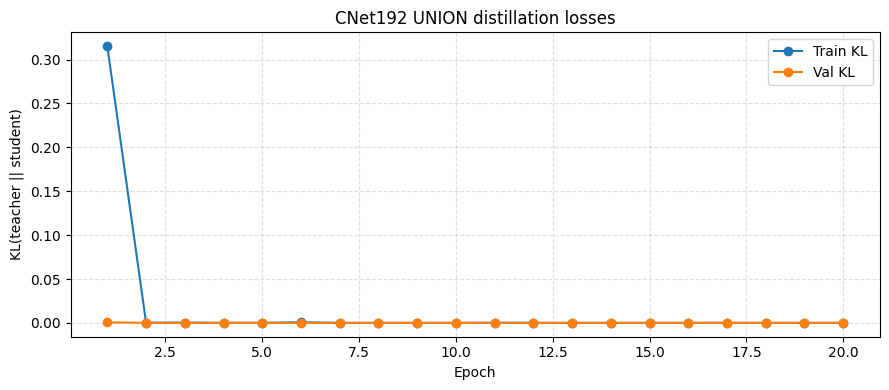

Greedy agreement vs first teacher (MIX_12a): 173/256 = 0.676


In [8]:
# Cell 8: loss plots + sanity checks (teacher vs student on random states)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111)
ax.plot(range(1, len(train_loss_history)+1), train_loss_history, marker="o", label="Train KL")
ax.plot(range(1, len(val_loss_history)+1),   val_loss_history,   marker="o", label="Val KL")
ax.set_title("CNet192 UNION distillation losses")
ax.set_xlabel("Epoch")
ax.set_ylabel("KL(teacher || student)")
ax.grid(True, ls="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

# --- quick behavioral sanity: compare greedy action agreement with first teacher on random env states ---
# If you distilled a single teacher, this should be high.
teacher0_name = TEACHER_NAMES[0]
teacher0 = TEACHERS[teacher0_name].eval()

# Load best checkpoint into a fresh model to avoid any train-mode weirdness.
best_model, best_meta = load_cnet192(BEST_PATH, device=DEVICE, strict=True)

def greedy_action(model, state_1x6x7: np.ndarray, legal: Sequence[int]) -> int:
    x = torch.from_numpy(state_1x6x7[None, :, :, :]).to(DEVICE)
    out = model(x)
    logits = out[0] if isinstance(out, (tuple, list)) else out
    # strict legal argmax
    legal = [int(a) for a in legal]
    vals = logits[0].detach().cpu().numpy().astype(np.float64, copy=False)
    best = max(legal, key=lambda c: float(vals[c]))
    return int(best)

rng = np.random.default_rng(SEED + 123)
agree = 0
total = 256

env = Connect4Env()
for _ in range(total):
    env.reset()
    done = False
    # play a few random moves to get a mid-game state
    for _k in range(int(rng.integers(0, 12))):
        legal = env.available_actions()
        if not legal:
            break
        a = int(rng.choice(legal))
        _, _, done = env.step(a)
        if done:
            break

    legal = env.available_actions()
    if not legal:
        continue

    s = env.get_state(perspective=env.current_player).astype(np.float32, copy=False)

    a_t = greedy_action(teacher0, s, legal)
    a_s = greedy_action(best_model, s, legal)

    if a_t == a_s:
        agree += 1

print(f"Greedy agreement vs first teacher ({teacher0_name}): {agree}/{total} = {agree/total:.3f}")
